In [44]:
#!pip install -Uq fastai huggingface_hub 

In [45]:
from constants import DatasetPath

import pandas as pd
import numpy as np
import torch
import timm
import os
import matplotlib.pyplot as plt

from torch import nn

from skimage import io

from tqdm.notebook import tqdm

from torchvision import transforms
from PIL import Image

In [46]:
import sys

print(sys.executable)

c:\Users\mario\Desktop\Biometria\DeepFake\.env\Scripts\python.exe


In [47]:
# Main Dataset folder path
DATA_DIR = DatasetPath.effectivePath

# Device to run calculations on 
DEVICE = 'cuda'

#CYCLE_GAN and PRO_GAN contains both real and fake images

REAL_DIRS = ["afhq", "celebahq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces", "cycle_gan", "pro_gan"]

FAKE_DIRS = ["big_gan", "cips", "cycle_gan", "ddpm", "denoising_diffusion_gan", "diffusion_gan", "face_synthetics", 
				 "gansformer", "gau_gan", "generative_inpainting", "glide", "lama", "latent_diffusion", "mat", "palette", 
				 "pro_gan", "projected_gan", "sfhq", "stable_diffusion", "star_gan", "stylegan1", "stylegan2", "stylegan3",
				 "taming_transformer", "vq_diffusion"]

In [48]:
# Read '.csv' file containing 'anchor', 'positive' and 'negative' triplets
df = pd.read_csv(DATA_DIR + "input.csv")

# Read '.csv' file containing BGR-Fourier path mappings 
mapping_df = pd.read_csv(DATA_DIR + "path_mapping.csv")

In [49]:
def plot_path_frequency_as_positive(df):
	"""
	Plot the frequency of paths in the 'positive' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'positive'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'positive' column with paths.
	"""
	
	# Calculate the frequency of 'positive' paths
	positive_counts = df['positive'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	positive_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Positive\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_path_frequency_as_negative(df):
	"""
	Plot the frequency of paths in the 'negative' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'negative'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'negative' column with paths.
	"""
	# Calculate the frequency of 'negative' paths
	negative_counts = df['negative'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	negative_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Negative\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_real_fake_count(df):
	"""
	Plot the count of 'real' and 'fake' paths in the DataFrame.

	This function calculates the total number of paths containing the substring
	'real' and 'fake' in the 'anchor', 'positive', and 'negative' columns of the
	provided DataFrame. It then plots these counts as a horizontal bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing 'anchor', 'positive', and 'negative' columns with paths.
	"""
	
	# Count occurrences of 'real' and 'fake' in the 'anchor' column
	real_count = df['anchor'].str.contains('real').sum()
	fake_count = df['anchor'].str.contains('fake').sum()

	# Prepare data for plotting
	counts = {'real': real_count, 'fake': fake_count}
	counts_df = pd.DataFrame(list(counts.items()), columns=['Type', 'Count'])

	# Plot horizontal bar chart
	ax = counts_df.plot(kind='barh', x='Type', y='Count', legend=False, color=['blue', 'red'])
	plt.title('Number of images in the Training Set per category')
	plt.xlabel('Count')
	plt.ylabel('Type')

	# Add text annotations to the bars
	for index, value in enumerate(counts_df['Count']):
		ax.text(value, index, str(value), va='center')

	# Expand x-axis to accommodate annotations
	plt.xlim(right=max(counts_df['Count']) * 1.2)

	plt.show()


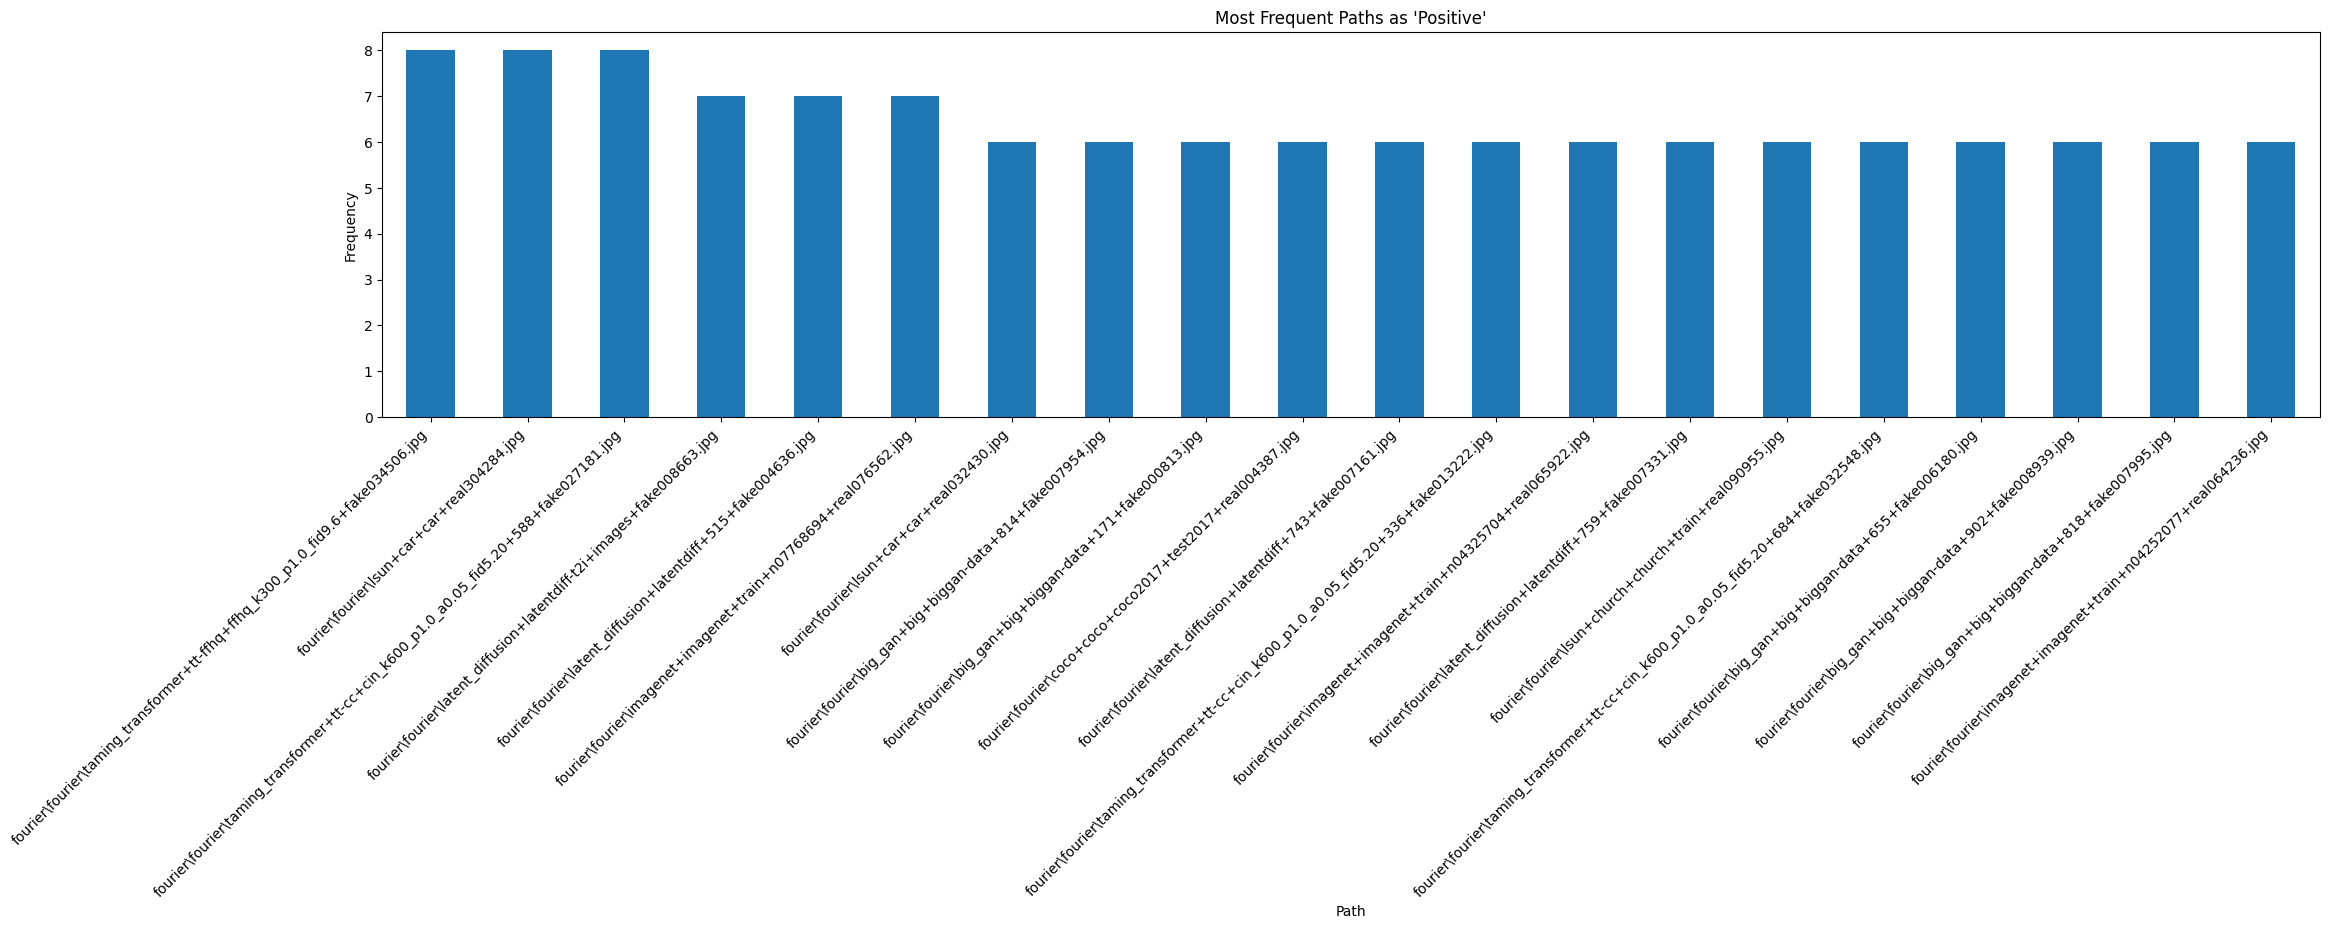

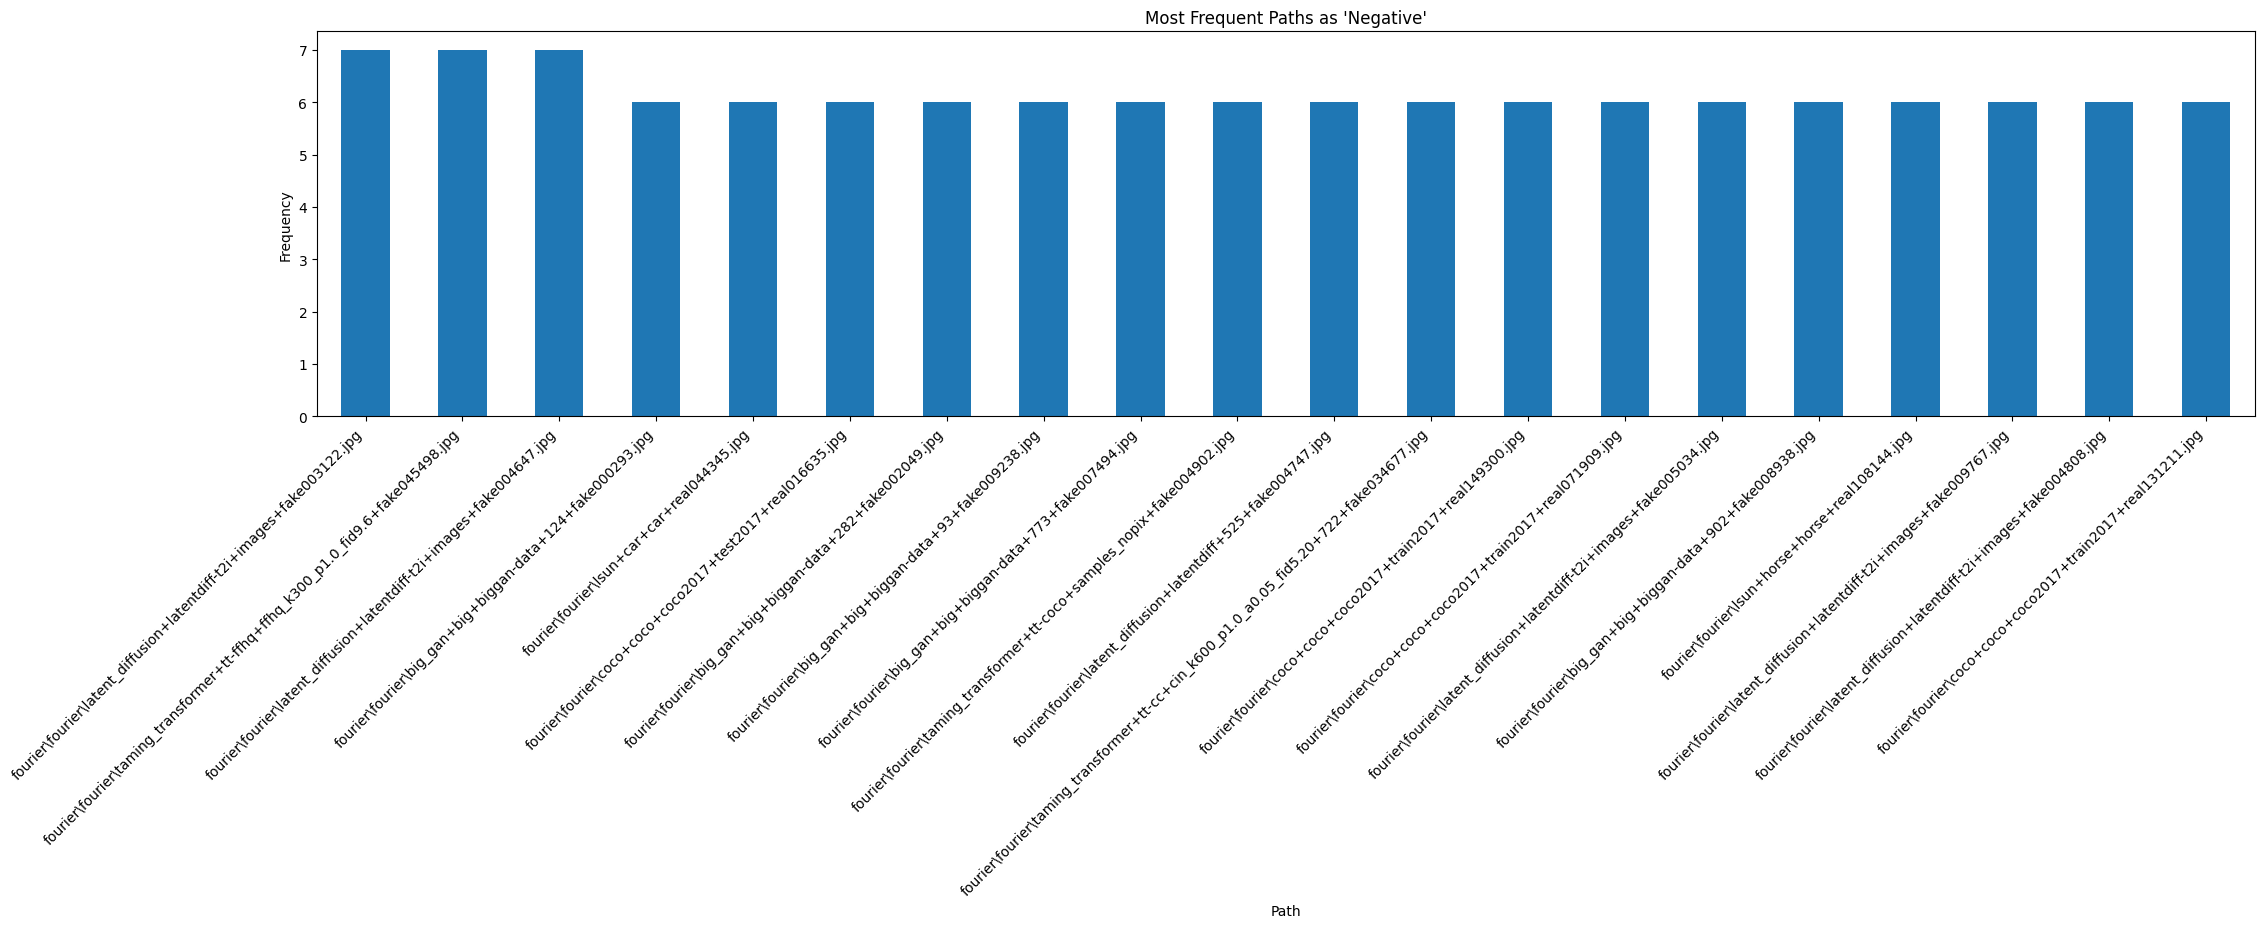

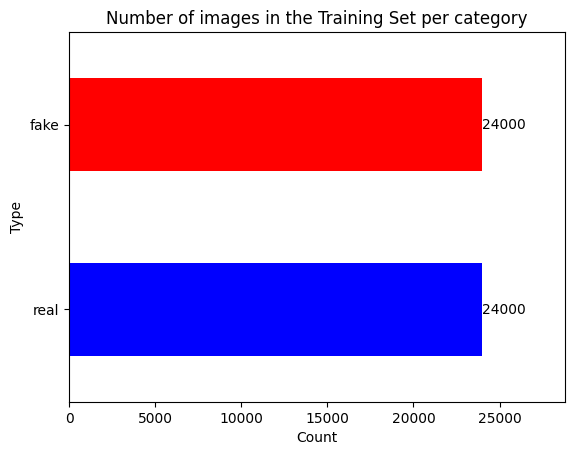

In [50]:
plot_path_frequency_as_positive(df)
plot_path_frequency_as_negative(df)
plot_real_fake_count(df)

In [51]:
class APN_Model(nn.Module):
	"""
	Defines a neural network model class APN_Model that uses an EfficientNet (specifically the B0 version) as its backbone.
	"""

	def __init__(self, emb_size = 512):
		"""
		Initializes the APN_Model with a specific model and a classifier that outputs embedding vector of the specified size.

		Parameters
		----------
		emb_size (int, optional): the size of the output embedding vector (default is 512).
		"""
		super(APN_Model, self).__init__()

		# Define the model to use 
		self.efficientnet = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained = True)
		
		# Replace the classifier layer with a linear layer that outputs embeddings of size `emb_size`
		self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

	def forward(self, images):
		"""
		Performs the forward pass of the model, which takes a batch of images and returns their embeddings.

		Parameters
		----------
			images (torch.Tensor): a batch of images to process.

		Returns
		-------
			embeddings (torch.Tensor): a batch of embeddings of size `emb_size`.
		"""
		embeddings = self.efficientnet(images)
		return embeddings

In [52]:
#from huggingface_hub import hf_hub_download

In [53]:
# NN mod to accept greyscale fourier spectrum images instead of RGB

model = APN_Model()
# model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act)

In [54]:
def getImageEmbeddings(img_path, model):
	"""
	Generates embeddings for a given image using the provided model.

	Parameters
	----------
		img_path (str): the path to the input image.
		model (torch.nn.Module): the PyTorch model used to generate the image embeddings.

	Returns
	-------
		img_enc (numpy.ndarray): the embeddings of the input image.
	"""
	preprocess = transforms.Compose([
        #transforms.Resize(200),  # Resize the image to 256x256 pixels
        #transforms.CenterCrop(200),  # Crop the center of the image to 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

	# Read the image from the specified directory
	#img = io.imread(DATA_DIR + img_path)

	# Add a new dimension to the image array to match the expected input shape of the model
	#img = np.expand_dims(img, 0)

	# Convert the NumPy array to a PyTorch tensor and normalize pixel values to the range [0, 1]
	#img = torch.from_numpy(img) / 255.0
	img = Image.open(DATA_DIR + img_path).convert('RGB')
	img = preprocess(img)  # Add a batch dimension

	# Set the model to evaluation mode
	model.eval()
	
	# Disable gradient calculation for efficiency
	with torch.no_grad():
		# Move the image tensor to the appropriate device (CPU or GPU)
		img = img.to(DEVICE)
		
		# Add a batch dimension, pass the image through the model to get the embeddings
		img_enc = model(img.unsqueeze(0))
		
		# Detach the embeddings from the computation graph and move them back to the CPU
		img_enc = img_enc.detach().cpu().numpy()
		
		# Convert the embeddings to a NumPy array
		img_enc = np.array(img_enc)

	return img_enc

In [55]:
def fourier_to_BGR_mapping(df, mapping_df):
    """
    Replaces frequency domain image paths with corresponding BGR image paths.

    Parameters
    ----------
    df (Pandas.Dataframe): the DataFrame containing the CSV file with the triplets having frequency domain paths.
    mapping_df (Pandas.Dataframe): the DataFrame containing the CSV file with the BGR-Fourier mappings

    """

    # Create a mapping dictionary from frequency paths to RGB paths
    path_mapping_dict = pd.Series(mapping_df['RGB Path'].values, index=mapping_df['Fourier Path']).to_dict()

    # Replace frequency paths with RGB paths directly
    df['anchor'] = df['anchor'].map(path_mapping_dict).fillna(df['anchor'])
    df['positive'] = df['positive'].map(path_mapping_dict).fillna(df['positive'])
    df['negative'] = df['negative'].map(path_mapping_dict).fillna(df['negative'])


    return df

In [56]:
df = fourier_to_BGR_mapping(df, mapping_df)
print(df)

                                                  anchor  \
0             coco/coco/coco2017/train2017/img155502.jpg   
1             coco/coco/coco2017/train2017/img135513.jpg   
2             coco/coco/coco2017/train2017/img059112.jpg   
3             coco/coco/coco2017/train2017/img041263.jpg   
4             coco/coco/coco2017/train2017/img082003.jpg   
...                                                  ...   
47995  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
47996  taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...   
47997  taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...   
47998  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
47999  taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...   

                                                positive  \
0        imagenet/imagenet/train/n04149813/img062483.jpg   
1             coco/coco/coco2017/train2017/img151699.jpg   
2                             lsun/cat/cat/img029275.jpg   
3                 lsun/church/church/tr

In [57]:
embedding_dict = {}  # Initialize an empty dictionary to store image embeddings

# Loop through each image path in the 'anchor' column of the DataFrame
for img_path in tqdm(df['anchor'], total=len(df), desc="Generating embeddings"):
	# Generate and store the embedding for each anchor image in the dictionary
	embedding_dict[img_path] = getImageEmbeddings(img_path, model)

# Map the embeddings to the 'anchor_emb' column using the paths from the 'anchor' column
df['anchor_emb'] = df['anchor'].map(embedding_dict)

# Map the embeddings to the 'positive_emb' column using the paths from the 'positive' column
df['positive_emb'] = df['positive'].map(embedding_dict)

# Map the embeddings to the 'negative_emb' column using the paths from the 'negative' column
df['negative_emb'] = df['negative'].map(embedding_dict)

Generating embeddings:   0%|          | 0/48000 [00:00<?, ?it/s]

In [58]:
def euclidean_distance(a, b):
	"""
	Calculate the Euclidean distance between two vectors.

	Parameters
	----------
	a (numpy.ndarray): the first vector.
	b (numpy.ndarray): the second vector.

	Returns
	-------
	(float): the Euclidean distance between vectors `a` and `b`.
	"""
	return np.linalg.norm(a - b)  # Calculate and return the Euclidean distance

In [59]:
# Calculate the distances between anchor and positive embeddings
df['dist_anchor_positive'] = [euclidean_distance(row['anchor_emb'], row['positive_emb']) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating distances (anchor-positive)")]

# Calculate the distances between anchor and negative embeddings
df['dist_anchor_negative'] = [euclidean_distance(row['anchor_emb'], row['negative_emb']) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating distances (anchor-negative)")]

Calculating distances (anchor-positive):   0%|          | 0/48000 [00:00<?, ?it/s]

Calculating distances (anchor-negative):   0%|          | 0/48000 [00:00<?, ?it/s]

In [60]:
margin = 0.2  # Set the margin for semi-hard triplets

# Filter the DataFrame to select semi-hard triplets based on the defined condition
semi_hard_triplets = df[
	(df['dist_anchor_positive'] < df['dist_anchor_negative']) &  # Check if the distance between anchor and positive embeddings is less than the distance between anchor and negative embeddings
	(df['dist_anchor_negative'] < (df['dist_anchor_positive'] + margin))  # Check if the distance between anchor and negative embeddings is less than the distance between anchor and positive embeddings plus the margin
]

# Print the semi-hard triplets
print(semi_hard_triplets)

                                                  anchor  \
7              coco/coco/coco2017/test2017/img038553.jpg   
9             coco/coco/coco2017/train2017/img110703.jpg   
15            coco/coco/coco2017/train2017/img112288.jpg   
17            coco/coco/coco2017/train2017/img094706.jpg   
23             coco/coco/coco2017/test2017/img028714.jpg   
...                                                  ...   
47969  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
47971  taming_transformer/tt-coco/samples_nopix/img00...   
47973  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   
47975  taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...   
47983  taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...   

                                                positive  \
7             coco/coco/coco2017/train2017/img069758.jpg   
9        imagenet/imagenet/train/n01819313/img007190.jpg   
15             coco/coco/coco2017/test2017/img013762.jpg   
17       imagenet/imagenet/train/n03792

In [61]:
def BGR_to_Fourier_mapping(df, mapping_df):
    """
    Replaces BGR image paths with corresponding frequency domain image paths.

    Parameters
    ----------
    df (Pandas.Dataframe): the DataFrame containing the CSV file with the triplets having BGR paths.
    mapping_df (Pandas.Dataframe): the DataFrame containing the CSV file with the BGR-Fourier mappings

    """
    # Create a mapping dictionary from RGB paths to frequency paths
    path_mapping_dict = pd.Series(mapping_df['Fourier Path'].values, index=mapping_df['RGB Path']).to_dict()

    # Replace frequency paths with RGB paths directly
    df['anchor'] = df['anchor'].map(path_mapping_dict).fillna(df['anchor'])
    df['positive'] = df['positive'].map(path_mapping_dict).fillna(df['positive'])
    df['negative'] = df['negative'].map(path_mapping_dict).fillna(df['negative'])


    return df

In [62]:
semi_hard_triplets = BGR_to_Fourier_mapping(semi_hard_triplets, mapping_df)
print(semi_hard_triplets)

                                                  anchor  \
7      fourier\fourier\coco+coco+coco2017+test2017+re...   
9      fourier\fourier\coco+coco+coco2017+train2017+r...   
15     fourier\fourier\coco+coco+coco2017+train2017+r...   
17     fourier\fourier\coco+coco+coco2017+train2017+r...   
23     fourier\fourier\coco+coco+coco2017+test2017+re...   
...                                                  ...   
47969  fourier\fourier\taming_transformer+tt-cc+cin_k...   
47971  fourier\fourier\taming_transformer+tt-coco+sam...   
47973  fourier\fourier\taming_transformer+tt-cc+cin_k...   
47975  fourier\fourier\taming_transformer+tt-ffhq+ffh...   
47983  fourier\fourier\taming_transformer+tt-cc+cin_k...   

                                                positive  \
7      fourier\fourier\coco+coco+coco2017+train2017+r...   
9      fourier\fourier\imagenet+imagenet+train+n01819...   
15     fourier\fourier\coco+coco+coco2017+test2017+re...   
17     fourier\fourier\imagenet+imagene

C:\Users\mario\AppData\Local\Temp\ipykernel_20992\3873441103.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anchor'] = df['anchor'].map(path_mapping_dict).fillna(df['anchor'])
C:\Users\mario\AppData\Local\Temp\ipykernel_20992\3873441103.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['positive'] = df['positive'].map(path_mapping_dict).fillna(df['positive'])
C:\Users\mario\AppData\Local\Temp\ipykernel_20992\3873441103.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [63]:
def df_to_csv(df, filename, path):
	"""
	Splits the DataFrame in chunks to enable tqdm progress visualization while converting the DataFrame into a '.csv' file.

	Parametres
	----------
		df (pd.DataFrame): the DataFrame to convert.
		filename (str): the desired file name (comprehensive of '.csv' extension).
		path (str): the path where the '.csv' will be stored.
	"""
	chunks = np.array_split(df.index, 100)
	for chunck, subset in enumerate(tqdm(chunks, desc="Creating \'" + filename + "\' file")):
		if chunck == 0: # first row
			df.loc[subset].to_csv(path, mode='w', index=False)
		else:
			df.loc[subset].to_csv(path, header=None, mode='a', index=False)

	print("\'" + filename + "\' has been successfully created.")

In [64]:
# Create a new DataFrame containing only the 'anchor', 'positive', and 'negative' columns from semi_hard_triplets
filtered_input_df = semi_hard_triplets[['anchor', 'positive', 'negative']].copy()

# Print the selected triplets DataFrame
print(filtered_input_df)

# Save to '.csv'
df_to_csv(filtered_input_df, "filtered_input.csv", DATA_DIR + "filtered_input.csv")

                                                  anchor  \
7      fourier\fourier\coco+coco+coco2017+test2017+re...   
9      fourier\fourier\coco+coco+coco2017+train2017+r...   
15     fourier\fourier\coco+coco+coco2017+train2017+r...   
17     fourier\fourier\coco+coco+coco2017+train2017+r...   
23     fourier\fourier\coco+coco+coco2017+test2017+re...   
...                                                  ...   
47969  fourier\fourier\taming_transformer+tt-cc+cin_k...   
47971  fourier\fourier\taming_transformer+tt-coco+sam...   
47973  fourier\fourier\taming_transformer+tt-cc+cin_k...   
47975  fourier\fourier\taming_transformer+tt-ffhq+ffh...   
47983  fourier\fourier\taming_transformer+tt-cc+cin_k...   

                                                positive  \
7      fourier\fourier\coco+coco+coco2017+train2017+r...   
9      fourier\fourier\imagenet+imagenet+train+n01819...   
15     fourier\fourier\coco+coco+coco2017+test2017+re...   
17     fourier\fourier\imagenet+imagene

Creating 'filtered_input.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'filtered_input.csv' has been successfully created.


In [65]:
# Read the '.csv' file and load it into a DataFrame
df = pd.read_csv(DATA_DIR + "filtered_input.csv")

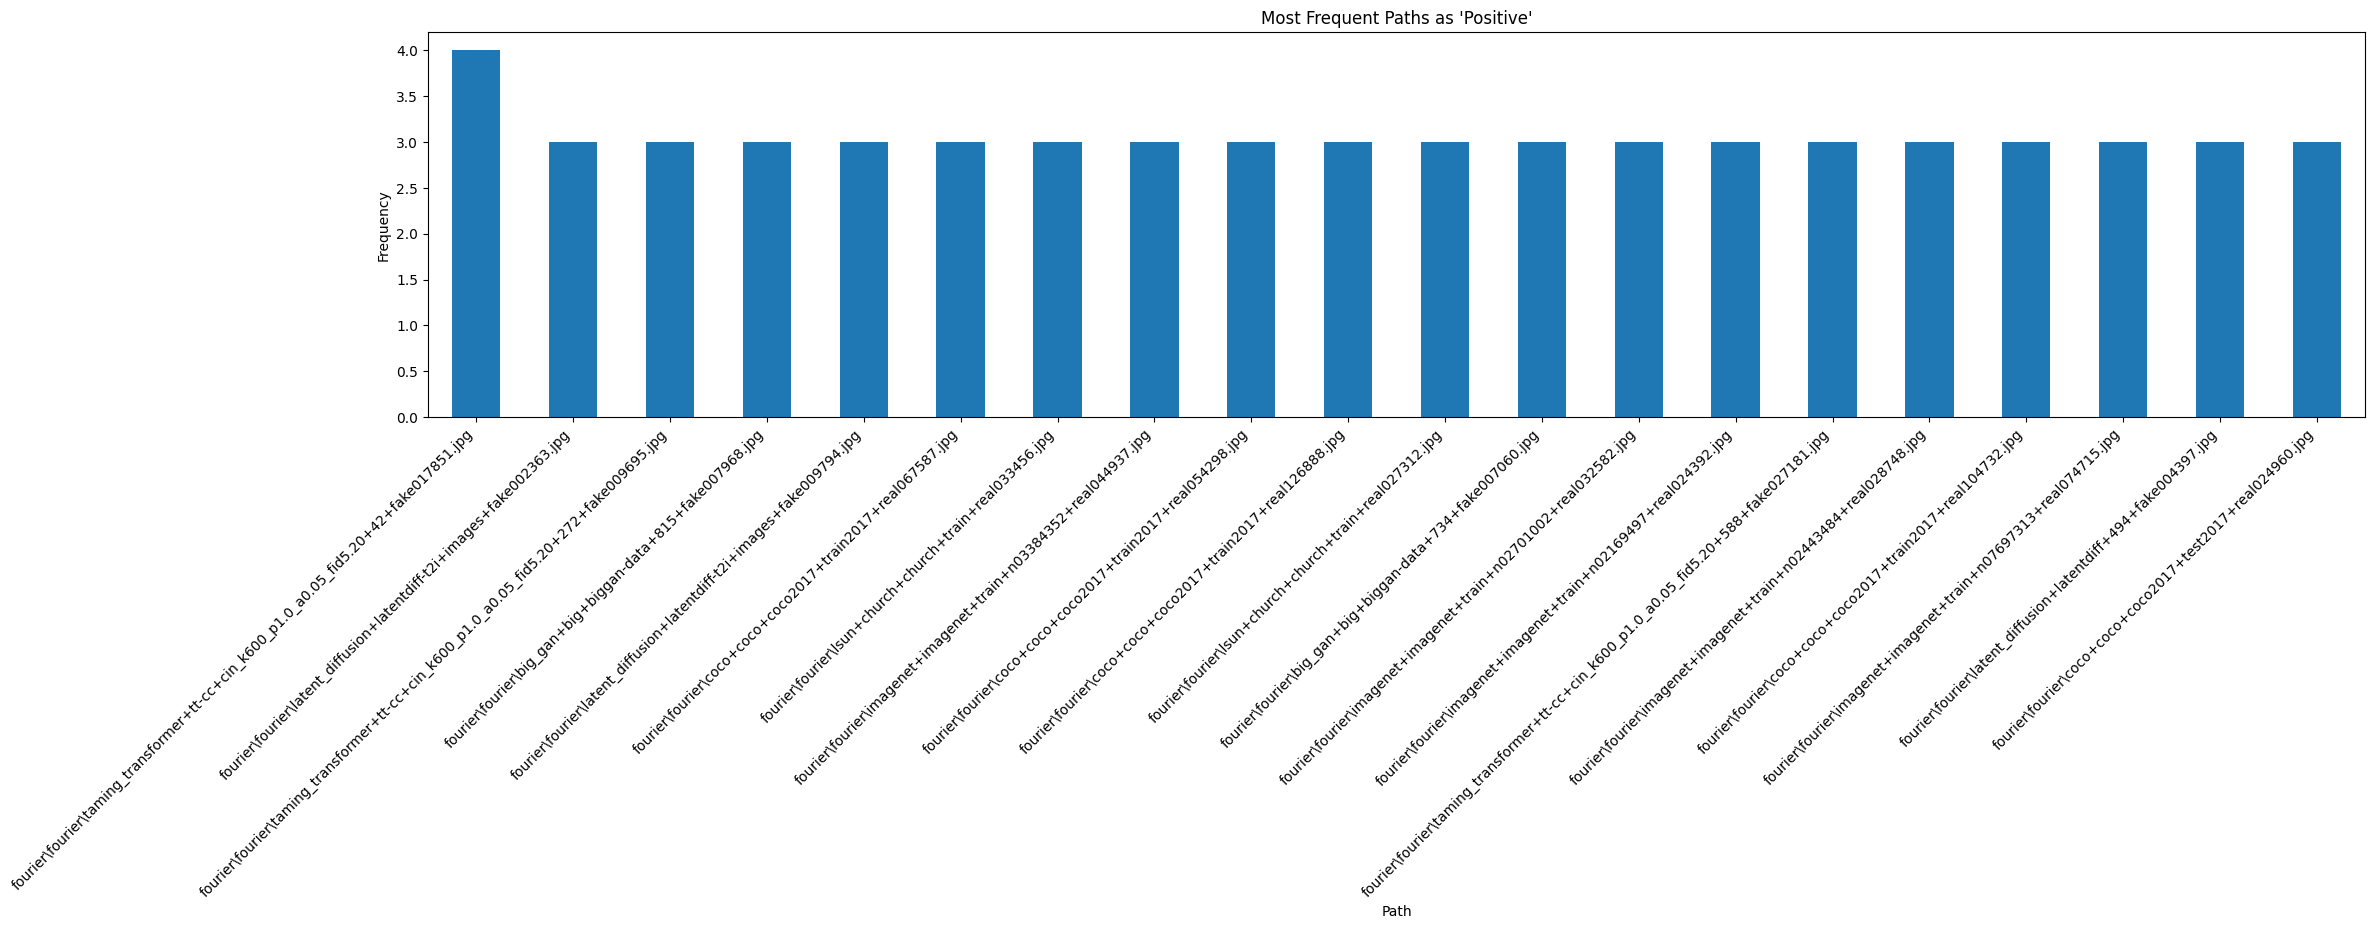

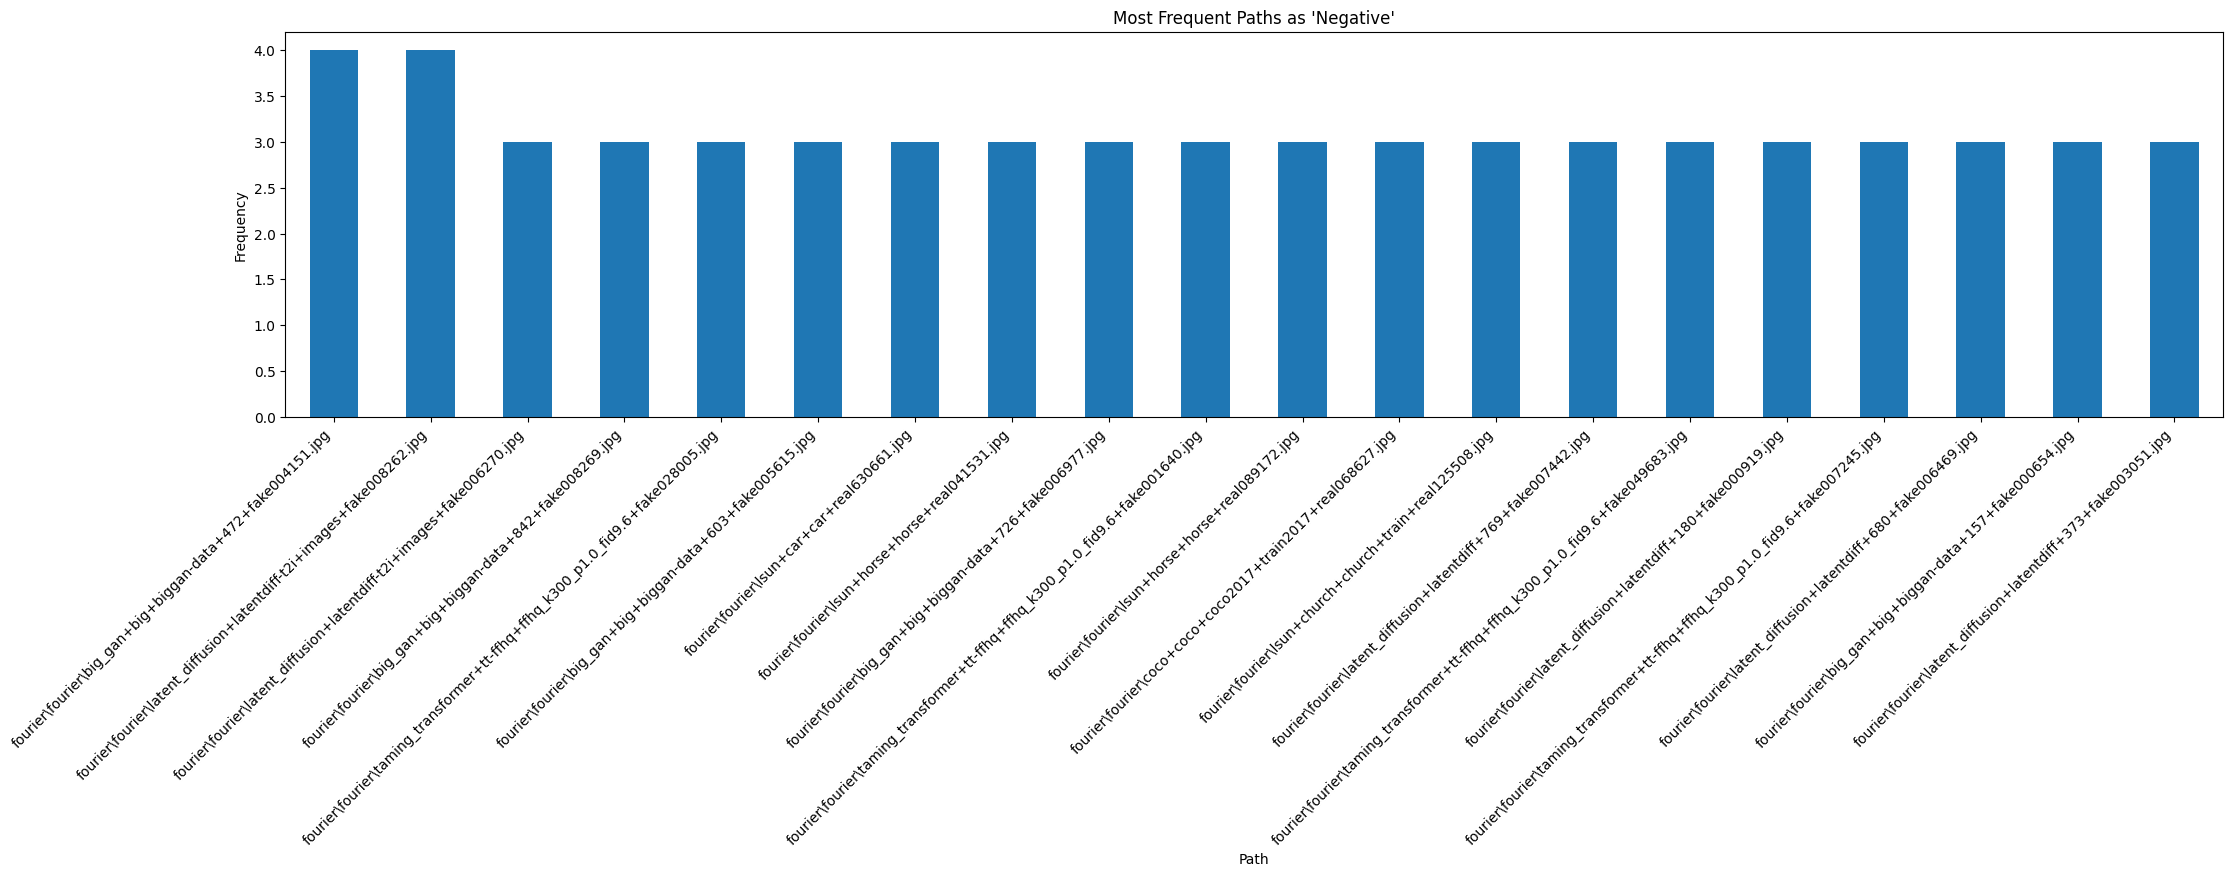

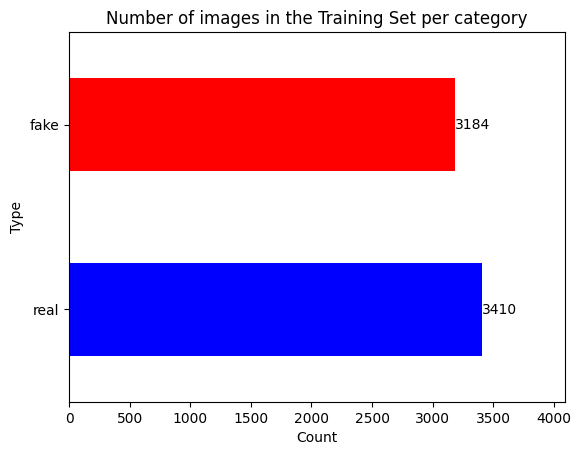

In [66]:
plot_path_frequency_as_positive(df)
plot_path_frequency_as_negative(df)
plot_real_fake_count(df)

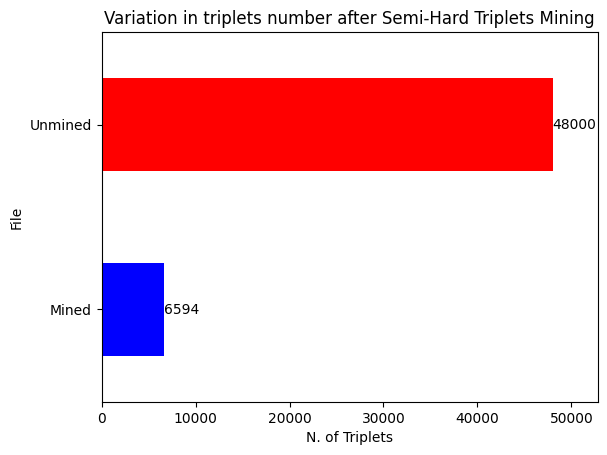

In [67]:
# Read lengths of CSV files
input_length = len(pd.read_csv(DATA_DIR + 'input.csv'))
filtered_input_length = len(df)

# Prepare data for plotting
lengths = {'Mined': filtered_input_length, 'Unmined': input_length}
lengths_df = pd.DataFrame(list(lengths.items()), columns=['File', 'Length'])

# Plot horizontal bar chart
ax = lengths_df.plot(kind='barh', x='File', y='Length', legend=False, color=['blue', 'red'])
plt.title('Variation in triplets number after Semi-Hard Triplets Mining')
plt.xlabel('N. of Triplets')
plt.ylabel('File')

# Add text annotations to the bars
for index, value in enumerate(lengths_df['Length']):
	ax.text(value, index, str(value), va='center')

# Expand x-axis to accommodate annotations
plt.xlim(right=max(lengths_df['Length']) * 1.1)

plt.show()

In [68]:
# The following code adresses the issue with path differences beetween Google and Windows when colab is used 
# (This doesn't change anything if colab wasn't used)

# Replace '\' with '/' in the whole file
df = df.applymap(lambda x: x.replace('/', '\\') if isinstance(x, str) else x)

# Overwrite the '.csv' file with the updated DataFrame
if os.path.exists(DATA_DIR + "filtered_input.csv"):
		os.remove(DATA_DIR + "filtered_input.csv")
df.to_csv(DATA_DIR + "filtered_input.csv", index=False)

C:\Users\mario\AppData\Local\Temp\ipykernel_20992\4106481676.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('/', '\\') if isinstance(x, str) else x)


In [69]:
def get_input_dirs(filtered_input_df):
	"""
	Retrieves image source directories from the dataset.

	Parameters
	----------
		filtered_input_df (pandas.DataFrame): the dataframe containing the semi-hard mined triplets.
	Returns
	-------
		real_dirs (set of str): a set of unique directories that contain real images.
		fake_dirs (set of str): a set of unique directories that contain fake images.
	"""
	# Initialize lists to store directories for real and fake images
	real_dirs_list = []
	fake_dirs_list = []

	# Iterate through each row in the dataframe with a progress bar
	for index, row in tqdm(filtered_input_df.iterrows(), total=filtered_input_df.shape[0]):
		# Extract the top-level directory from the image path
		dir = row["anchor"].split('fourier\\fourier\\')[1].split('+')[0]

		# Categorize the directory as 'real' or 'fake' based on its presence in REAL_DIRS
		if dir in REAL_DIRS:
			real_dirs_list.append(dir)
		else:
			fake_dirs_list.append(dir)

	real_dirs = sorted(set(real_dirs_list))
	fake_dirs = sorted(set(fake_dirs_list))

	# Return the lists of real and fake directories
	return real_dirs, fake_dirs


def train_test_split_rebalance(filtered_input_df, test_df):
	"""
	Rebalances the test dataset to achieve an 80/20 train-test split ratio.

	This function rebalances the test dataset by dropping a calculated number of 
	samples from each directory of real and fake images to achieve an 80/20 
	train-test split ratio. The function also saves the old test set before 
	rebalancing.

	Parameters
	----------
	filtered_input_df (pandas.DataFrame): the DataFrame containing the filtered input data.
	test_df (pandas.DataFrame): the DataFrame containing the initial test data.

	Notes
	-----
	- This function assumes the presence of 'real' and 'fake' columns in the 
	  `test_df` DataFrame, which contain paths to the real and fake images, 
	  respectively.
	- The function will save the old test set to a CSV file named 
	  "unbalanced_testSet.csv" and the rebalanced test set to a CSV file named 
	  "testSet.csv" in the directory specified by `DATA_DIR`.
	- The function uses the helper function `get_input_dirs` to obtain directories 
	  containing real and fake images and `df_to_csv` to save DataFrames to CSV files.
	"""
	
	# Initialization
	balanced_test_df = pd.DataFrame(columns=['real', 'fake'])
	input_size = len(filtered_input_df)
	real_dirs, fake_dirs = get_input_dirs(filtered_input_df)
	print(real_dirs)
	print(fake_dirs)

	rebalanced_size = round(input_size * 20 / 80)
	print(f"Current Test set size:{len(test_df) * 2}(Train-Test split ratio: {(input_size * 100 / (input_size + (len(test_df)* 2))):.2f}/{(len(test_df) * 2 * 100 / (input_size + (len(test_df)* 2))):.2f})")
	print(f"Balanced Test set size:{rebalanced_size}(Train-Test split ratio: 80/20)")

	# Number of tuples to sample from each real images directory
	real_sample_size = round(rebalanced_size / 2 / len(real_dirs))
	i = 1
	#Iterate through the dataset partition and sample the same number of tuples for each fake images directory
	for dir in tqdm(real_dirs, desc="Test set Real images sampling"):
		sampled_size = 0
		for index, row in test_df.iterrows():
			if sampled_size < real_sample_size:
				image_path = row["real"]
				splitted_path = image_path.split('fourier\\fourier\\')[1].split('+')[0]
				if dir==splitted_path:
					balanced_test_df.loc[i] = [image_path, None]
					sampled_size+=1
					i+=1
			else: break
	
	# Number of tuples to sample from each fake images directory
	fake_sample_size = round(rebalanced_size / 2 / len(fake_dirs))
	i = 1
	#Iterate through the dataset partition and sample the same number of tuples for each fake images directory
	for dir in tqdm(fake_dirs, desc="Test set Fake images sampling"):
			sampled_size = 0
			for index, row in test_df.iterrows():
					if sampled_size < fake_sample_size:
							image_path = row["fake"]
							splitted_path = image_path.split('fourier\\fourier\\')[1].split('+')[0]
							if dir == splitted_path:
									balanced_test_df.loc[i] = [balanced_test_df.loc[i]["real"], image_path]
									sampled_size+=1
									i+=1

					else: break
	
	print(f"Test Set size after operations:{len(balanced_test_df) * 2}")

	# Store the old version of the Test Set and Overwrite the Test Set with the rebalanced one
	df_to_csv(test_df, "unbalanced_testSet.csv", DATA_DIR + "unbalanced_testSet.csv")
	if os.path.exists(DATA_DIR + "testSet.csv"):
		os.remove(DATA_DIR + "testSet.csv")
	df_to_csv(balanced_test_df, "testSet.csv", DATA_DIR + "testSet.csv") 

In [70]:
filtered_input_df = pd.read_csv(DATA_DIR + "filtered_input.csv")
test_df = pd.read_csv(DATA_DIR + "testSet.csv")

train_test_split_rebalance(filtered_input_df, test_df)

  0%|          | 0/6594 [00:00<?, ?it/s]

['coco', 'imagenet', 'lsun']
['big_gan', 'latent_diffusion', 'taming_transformer']
Current Test set size:12000(Train-Test split ratio: 35.46/64.54)
Balanced Test set size:1648(Train-Test split ratio: 80/20)


Test set Real images sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Test set Fake images sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Test Set size after operations:1650


Creating 'unbalanced_testSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'unbalanced_testSet.csv' has been successfully created.


Creating 'testSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'testSet.csv' has been successfully created.
